In [1]:
import cell2cell as c2c

%matplotlib inline

# Use toy data

**RNA-seq data**

In this case is a 6x5 matrix (6 genes/proteins and 5 samples/cell types). The values are arbitrary; for simplicity we will use them as TPMs. The indexes of this DataFrame are the names of the genes/proteins, while the columns are the names of samples/cell types.

In [2]:
rnaseq = c2c.datasets.generate_toy_rnaseq()

In [3]:
rnaseq

,C1,C2,C3,C4,C5
gene_id,,,,,
Protein-A,5,10,8,15,2
Protein-B,15,5,20,1,30
Protein-C,18,12,5,40,20
Protein-D,9,30,22,5,2
Protein-E,2,1,1,27,15
Protein-F,30,11,16,5,12


**Protein-Protein Interactions or Ligand-Receptor Pairs**

In this case, we use a list of LR pairs where some proteins also are ***complexes of multiple subunits***. The complexes are represented as a joint name of ***all subunits*** composing each complex, but ***separated by a separator '&'***. The ligands are in the column 'A', while the receptors in the column 'B'. For these purposes we do not use the column 'score'.

**The names of genes/proteins have to match those in the rnaseq dataset.**

In [4]:
ppi = c2c.datasets.generate_toy_ppi(prot_complex=True)

In [5]:
ppi

,A,B,score
0,Protein-A,Protein-B,1.0
1,Protein-B,Protein-C,1.0
2,Protein-C,Protein-A,1.0
3,Protein-B,Protein-B,1.0
4,Protein-B,Protein-A,1.0
5,Protein-E,Protein-F,1.0
6,Protein-F,Protein-F,1.0
7,Protein-C&Protein-E,Protein-F,1.0
8,Protein-B,Protein-E,1.0
9,Protein-A&Protein-B,Protein-F,1.0


**Metadata**

The metadata contains the extra information for the samples/cell types in the RNA-seq data. This dataframe must contain a column where the samples/cell types are specified (#SampleID) and another with the new information, for example major groups for the samples/cell types (Groups)

In [6]:
meta = c2c.datasets.generate_toy_metadata()

In [7]:
meta

,#SampleID,Groups
0,C1,G1
1,C2,G2
2,C3,G3
3,C4,G3
4,C5,G1


# Cell-cell Interactions and Communication Analysis

**Using an Interaction Pipeline**

The pipeline integrates the RNA-seq and PPI datasets by using the analysis setups. It generates an interaction space containing an instance for each sample/cell type, containing the values assigned to each protein in the PPI list given the setups for computing the CCI and CCC scores.

In this case is for bulk data since the toy data is not for single cell.

In [8]:
interactions = c2c.analysis.BulkInteractions(rnaseq_data=rnaseq,
                                             ppi_data=ppi,
                                             metadata=meta, # Metadata about cells/samples
                                             interaction_columns=('A', 'B'), # PPI columns
                                             complex_sep='&', # For protein complexes
                                             communication_score='expression_thresholding',
                                             expression_threshold=10, # TPMs
                                             cci_score='bray_curtis',
                                             cci_type='undirected',
                                             sample_col='#SampleID',
                                             group_col='Groups',
                                             verbose=False)

**Compute communication scores for each PPI or LR pair**

In [9]:
interactions.compute_pairwise_communication_scores()

Computing pairwise communication
Computing communication score between C1 and C1
Computing communication score between C2 and C4
Computing communication score between C3 and C3
Computing communication score between C3 and C2
Computing communication score between C4 and C3
Computing communication score between C5 and C1
Computing communication score between C1 and C2
Computing communication score between C5 and C3
Computing communication score between C5 and C2
Computing communication score between C1 and C5
Computing communication score between C2 and C5
Computing communication score between C3 and C5
Computing communication score between C4 and C1
Computing communication score between C2 and C2
Computing communication score between C5 and C4
Computing communication score between C4 and C2
Computing communication score between C1 and C4
Computing communication score between C2 and C1
Computing communication score between C4 and C5
Computing communication score between C3 and C1
Computi

**Compute CCI scores for each pair of cells**

It is computed according to the analysis setups. We computed an undirected Bray-Curtis-like score for each pair, meaning that score(C1, C2) = score(C2, C1).
**Notice that our score is undirected, so for C1 and C2 was not necessary to compute C2 and C1 as happened for the communication scores**

In [10]:
interactions.compute_pairwise_cci_scores()

Computing pairwise interactions
Computing interaction score between C3 and C4
Computing interaction score between C2 and C2
Computing interaction score between C1 and C1
Computing interaction score between C2 and C4
Computing interaction score between C3 and C3
Computing interaction score between C1 and C5
Computing interaction score between C5 and C5
Computing interaction score between C2 and C5
Computing interaction score between C1 and C4
Computing interaction score between C4 and C5
Computing interaction score between C1 and C2
Computing interaction score between C3 and C5
Computing interaction score between C2 and C3
Computing interaction score between C4 and C4
Computing interaction score between C1 and C3


# Visualizations

If we want to save the figure as a vector figure, we can pass a pathname into the filename input to save it. E.g. ***filename='/Users/cell2cell/CommScores.svg'***

**Generate colors for the groups in the metadata**

It returns a dictionary with the colors.

In [11]:
colors = c2c.plotting.get_colors_from_labels(labels=meta['Groups'].unique().tolist(),
                                             cmap='tab10'
                                            )

In [12]:
colors

{'G1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'G2': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 'G3': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)}

**Visualize communication scores for each LR pair and each cell pair**

Interaction space detected as a Interactions class


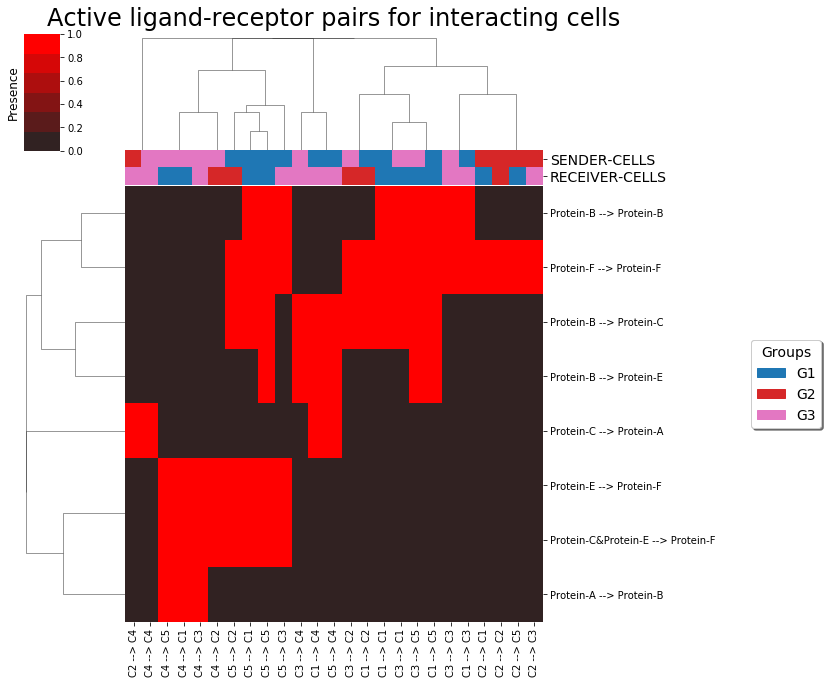

In [13]:
interaction_clustermap = c2c.plotting.clustermap_ccc(interactions,
                                                     metric='jaccard',
                                                     method='complete',
                                                     metadata=meta,
                                                     sample_col='#SampleID',
                                                     group_col='Groups',
                                                     colors=colors,
                                                     row_fontsize=14,
                                                     title='Active ligand-receptor pairs for interacting cells',
                                                     filename=None,
                                                     cell_labels=('SENDER-CELLS', 'RECEIVER-CELLS'),
                                                     **{'figsize' : (10,9)}
                                                     )

# Add a legend to know the groups of the sender and receiver cells:
l1 = c2c.plotting.generate_legend(color_dict=colors,
                                  loc='center left',
                                  bbox_to_anchor=(20, -2), # Indicated where to include it
                                  ncol=1, fancybox=True,
                                  shadow=True,
                                  title='Groups',
                                  fontsize=14,
                                 )

**Circos plot**

It generates a circos plot, showing the cells producing ligands (sender_cells), according to a list of specific ligands (ligands) to the cells producing receptors (receiver_cells), according to a list of specific receptors (receptors). The order of these lists is preserved in the visualization. Elements that are not used are omitted and therefore not plotted (in this case those with a communication score of 0, specified in 'excluded_score').

In [14]:
sender_cells = ['C1', 'C2', 'C5']
receiver_cells = ['C2', 'C3', 'C4', 'C5']
ligands = ['Protein-C',
           'Protein-E',
           'Protein-C&Protein-E',
           'Protein F'
          ]
receptors = ['Protein-B',
             'Protein-C',
             'Protein-F',
             'Protein-A'
            ]

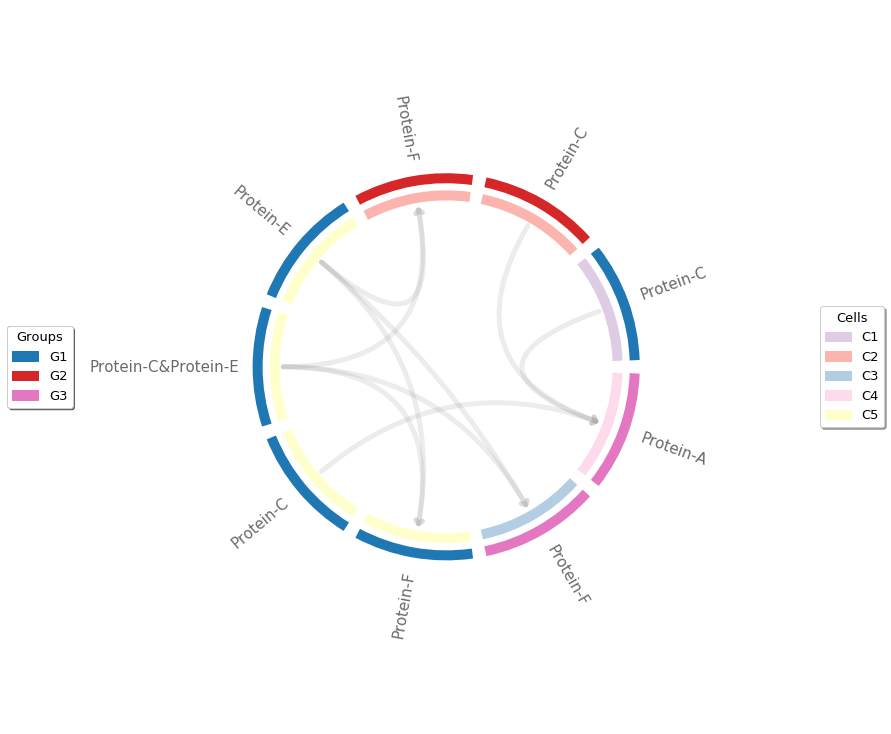

In [15]:
c2c.plotting.circos_plot(interaction_space=interactions,
                         sender_cells=sender_cells,
                         receiver_cells=receiver_cells,
                         ligands=ligands,
                         receptors=receptors,
                         excluded_score=0,
                         metadata=meta,
                         sample_col='#SampleID',
                         group_col='Groups',
                         colors=colors,
                         fontsize=15,
                        )

If we do not pass metadata info, the samples/cell types are only plotted.

We can also change the label colors of ligands and receptors

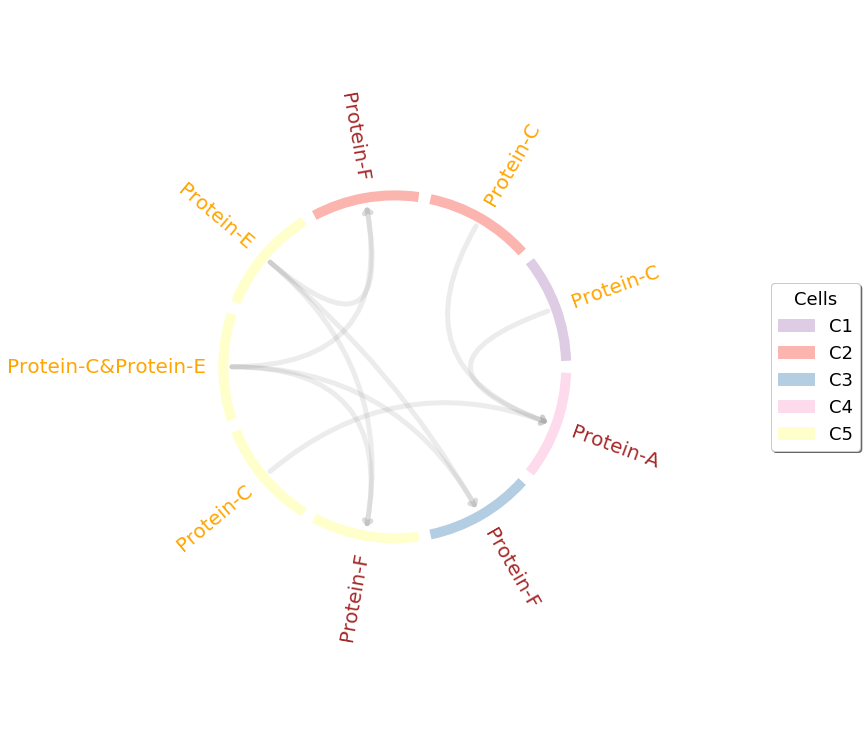

In [16]:
c2c.plotting.circos_plot(interaction_space=interactions,
                         sender_cells=sender_cells,
                         receiver_cells=receiver_cells,
                         ligands=ligands,
                         receptors=receptors,
                         excluded_score=0,
                         fontsize=20,
                         ligand_label_color='orange',
                         receptor_label_color='brown',
                        )

**Visualize CCI scores**

Since this case is undirected, a triangular heatmap is plotted instead of the complete one.

Interaction space detected as a Interactions class


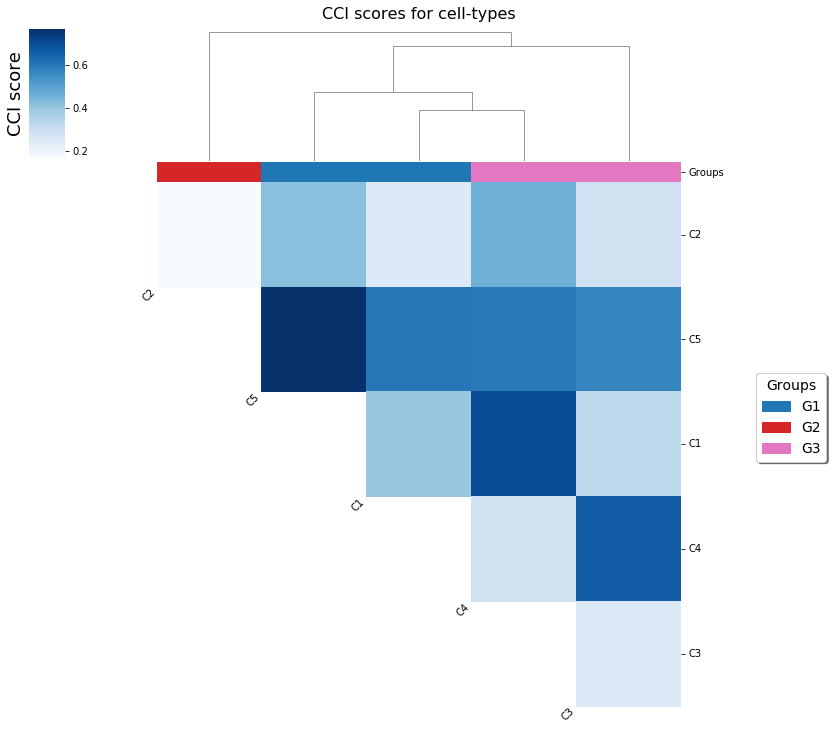

In [17]:
cm = c2c.plotting.clustermap_cci(interactions,
                                 method='complete',
                                 metadata=meta,
                                 sample_col="#SampleID",
                                 group_col="Groups",
                                 colors=colors,
                                 title='CCI scores for cell-types',
                                 cmap='Blues'
                                 )

# Add a legend to know the groups of the sender and receiver cells:
l1 = c2c.plotting.generate_legend(color_dict=colors,
                                  loc='center left',
                                  bbox_to_anchor=(20, -2), # Indicated where to include it
                                  ncol=1, fancybox=True,
                                  shadow=True,
                                  title='Groups',
                                  fontsize=14,
                                 )

**Project samples/cells with PCoA into a Euclidean space**

We can project the samples/cells given their CCI scores with other cells and see how close they are given their potential of interaction.

**THIS ONLY WORKS WITH UNDIRECTED CCI SCORES**

Interaction space detected as a Interactions class


/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell/cell2cell/external/pcoa.py:144: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03820849172269364 and the largest is 0.30170632330256536.
  RuntimeWarning


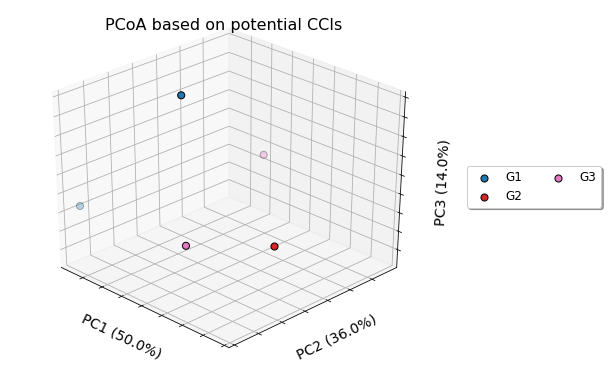

In [18]:
if interactions.analysis_setup['cci_type'] == 'undirected':
        
    pcoa = c2c.plotting.pcoa_3dplot(interactions,
                                    metadata=meta,
                                    sample_col="#SampleID",
                                    group_col="Groups",
                                    title='PCoA based on potential CCIs',
                                    colors=colors,
                                    )